In [7]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

In [2]:
BASE_OUTPUT_PATH = '/Users/richardross/workspace/msds/dsc-395t-nlp-final-project/fp-dataset-artifacts/output_new'

In [13]:
# Note: This comes from the ChaosNLI github repository:
# https://github.com/easonnie/ChaosNLI/blob/master/distnli/src/evaluation/tools.py#L24
def model_label_dist(logits_list):

    logits = np.asarray(logits_list)
    prob = np.exp(logits_list) / np.sum(np.exp(logits_list))

    # numerical stability for KL
    for i, value in enumerate(prob):
        if np.abs(value) < 1e-15:
            prob[i] = 1e-15
    
    # normalize
    prob = prob / np.sum(prob)
    assert np.isclose(np.sum(prob), 1)
    
    return prob


def generate_metrics_dict(df):
    
    return {'acc': len(df.query('label_g == predicted_label'))/len(df),
            'jsd': df.jsd.mean(),
            'kld': df.kld.mean()}


def generate_all_metrics_dict(df):

    return {'all': generate_metrics_dict(eval_df),
            'no-ambiguity': generate_metrics_dict(eval_df.query('amb_level == 0')),
            'medium-ambiguity': generate_metrics_dict(eval_df.query('amb_level == 1')),
            'high-ambiguity': generate_metrics_dict(eval_df.query('amb_level == 2'))}


def calculate_example_metrics(df):

    df['predicted_probs'] = df.apply(lambda x: model_label_dist(x.predicted_scores), axis=1)
    df['jsd'] = df.apply(lambda x: jensenshannon(x.label, x.predicted_probs), axis=1)
    df['kld'] = df.apply(lambda x: entropy(x.label, x.predicted_probs), axis=1)
    df['amb_level'] = df.apply(lambda x: get_ambiguity_level(x), axis=1)

    return df


def get_ambiguity_level(x):

    # this whole thing is a bit klugy, but <shrug> it works since there might be some fp imprecision.
    label_count = max(x.label)*5

    if label_count > 4.5:
        return 0
    elif label_count > 3.5:
        return 1
    else:
        return 2

### Analyze the baseline predictions

In [14]:
eval_df = pd.read_json(f'{BASE_OUTPUT_PATH}/trained_model_snli_baseline/eval_from_train_dev_baseline_on_test_gold_labels/eval_predictions.jsonl', lines=True)

In [15]:
eval_df.head(5)

,gold_label,premise,hypothesis,label,label_g,predicted_scores,predicted_label
0,neutral,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,"[0.0, 0.6000000000000001, 0.4]",1,"[-4.76672887802124, 2.198574781417846, 1.88465...",1
1,entailment,This church choir sings to the masses as they ...,The church is filled with song.,"[0.8, 0.2, 0.0]",0,"[4.445659637451172, -1.5746217966079712, -3.62...",0
2,contradiction,This church choir sings to the masses as they ...,A choir singing at a baseball game.,"[0.0, 0.0, 1.0]",2,"[-3.729947805404663, -2.421439170837402, 5.604...",2
3,neutral,"A woman with a green headscarf, blue shirt and...",The woman is young.,"[0.0, 1.0, 0.0]",1,"[-2.171307563781738, 4.768043041229248, -3.015...",1
4,entailment,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,"[0.6000000000000001, 0.2, 0.2]",0,"[3.8882577419281, -0.464171677827835, -4.16847...",0


In [16]:
eval_df = calculate_example_metrics(eval_df)
generate_all_metrics_dict(eval_df)

{'all': {'acc': 0.8748982084690554,
  'jsd': 0.2003502430164696,
  'kld': 0.8838935015687398},
 'no-ambiguity': {'acc': 0.9397097134350577,
  'jsd': 0.07225231323663986,
  'kld': 0.28704277771898407},
 'medium-ambiguity': {'acc': 0.8676419366074538,
  'jsd': 0.31293194168363136,
  'kld': 1.2630094438199184},
 'high-ambiguity': {'acc': 0.6675110829639012,
  'jsd': 0.43162080524787133,
  'kld': 2.2259035837507875}}

From this, we can see that accuracy drops dramatically as the ambiguity level increases. Can 

{'all': {'acc': 0.8905741042345277,
  'jsd': 0.21167255341506863,
  'kld': 0.2573941631956475},
 'no-ambiguity': {'acc': 0.9542240416821735,
  'jsd': 0.18507676339716447,
  'kld': 0.1685656369707211},
 'medium-ambiguity': {'acc': 0.8861024033437827,
  'jsd': 0.2219503197507553,
  'kld': 0.2965972979670458},
 'high-ambiguity': {'acc': 0.682077264091197,
  'jsd': 0.28350175443245973,
  'kld': 0.4884342518619364}}

#### Let's look at the confusion matrix (and other stats)

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [13]:
y_test = joined_df.label
y_pred = joined_df.predicted_label

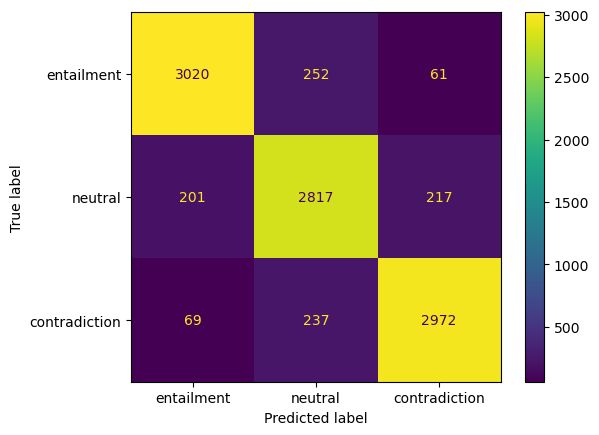

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['entailment','neutral','contradiction'])
plt.show()

In [16]:
def al_to_cnt(al):
    
    counter = Counter(al)
    return counter.most_common(1)[0][1]

joined_df['majority_cnt'] = joined_df.apply(lambda x: al_to_cnt(x['annotator_labels']), axis=1)

In [20]:
errors_df = joined_df.query('label != predicted_label')

In [62]:
errors_df.head()

,premise,hypothesis,label,predicted_scores,predicted_label,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse,gold_label_int,majority_cnt
4,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,1,"[-4.107326030731201, -1.11275315284729, 3.3734...",2,"[neutral, neutral, neutral, entailment, entail...",2407214681.jpg#0,neutral,2407214681.jpg#0r1n,"Two young children in blue jerseys, one with t...",( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,Two kids at a ballgame wash their hands.,( ( ( Two kids ) ( at ( a ballgame ) ) ) ( ( w...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...,1,3
20,A woman is doing a cartwheel while wearing a b...,A woman is doing a cartwheel and falls on her ...,2,"[-3.460534811019897, 3.49575662612915, -0.8049...",1,"[neutral, neutral, contradiction, contradictio...",3948003394.jpg#1,contradiction,3948003394.jpg#1r1n,A woman is doing a cartwheel while wearing a b...,( ( A woman ) ( ( is ( ( doing ( a ( cartwheel...,(ROOT (S (NP (DT A) (NN woman)) (VP (VBZ is) (...,A woman is doing a cartwheel and falls on her ...,( ( A woman ) ( ( ( ( is ( doing ( a cartwheel...,(ROOT (S (NP (DT A) (NN woman)) (VP (VP (VBZ i...,2,3
39,"At an outdoor event in an Asian-themed area, a...",A single man is next to a camera,2,"[1.664672255516052, -0.246294558048248, -1.586...",0,"[contradiction, contradiction, contradiction, ...",3261712960.jpg#0,contradiction,3261712960.jpg#0r1c,"At an outdoor event in an Asian-themed area, a...",( ( At ( ( an ( outdoor event ) ) ( in ( an ( ...,(ROOT (S (PP (IN At) (NP (NP (DT an) (JJ outdo...,A single man is next to a camera,( ( A ( single man ) ) ( is ( next ( to ( a ca...,(ROOT (S (NP (DT A) (JJ single) (NN man)) (VP ...,2,3
41,"At an outdoor event in an Asian-themed area, a...",A crowd is in front of a camera,1,"[3.9304652214050293, -0.6780596971511841, -3.6...",0,"[entailment, neutral, neutral, entailment, neu...",3261712960.jpg#0,neutral,3261712960.jpg#0r1e,"At an outdoor event in an Asian-themed area, a...",( ( At ( ( an ( outdoor event ) ) ( in ( an ( ...,(ROOT (S (PP (IN At) (NP (NP (DT an) (JJ outdo...,A crowd is in front of a camera,( ( A crowd ) ( is ( in ( front ( of ( a camer...,(ROOT (S (NP (DT A) (NN crowd)) (VP (VBZ is) (...,1,3
61,A man in a green jersey and rollerskates stumb...,They both fall to the ground.,1,"[-2.8914308547973633, -1.108787894248962, 2.60...",2,"[neutral, neutral, neutral, neutral, neutral]",6291644661.jpg#2,neutral,6291644661.jpg#2r1n,A man in a green jersey and rollerskates stumb...,( ( ( A man ) ( in ( ( ( a ( green jersey ) ) ...,(ROOT (S (NP (NP (DT A) (NN man)) (PP (IN in) ...,They both fall to the ground.,( They ( both ( ( fall ( to ( the ground ) ) )...,(ROOT (S (NP (PRP They)) (DT both) (VP (VBP fa...,1,5


In [77]:
import re
regex = r'one|two|three|four|five|six|seven|eight|nine|ten'
number_errors_df = errors_df[errors_df.apply(lambda x: re.search(regex, x['premise'], re.IGNORECASE) is not None, axis=1)]

In [79]:
number_errors_df[['premise', 'hypothesis', 'label', 'predicted_label', 'predicted_scores']].style.set_properties(**{'width': '500px'})


,premise,hypothesis,label,predicted_label,predicted_scores
4,"Two young children in blue jerseys, one with the number 9 and one with the number 2 are standing on wooden steps in a bathroom and washing their hands in a sink.",Two kids at a ballgame wash their hands.,1,2,"[-4.107326030731201, -1.11275315284729, 3.373436212539673]"
39,"At an outdoor event in an Asian-themed area, a crowd congregates as one person in a yellow Chinese dragon costume confronts the camera.",A single man is next to a camera,2,0,"[1.664672255516052, -0.246294558048248, -1.586862206459045]"
41,"At an outdoor event in an Asian-themed area, a crowd congregates as one person in a yellow Chinese dragon costume confronts the camera.",A crowd is in front of a camera,1,0,"[3.9304652214050293, -0.6780596971511841, -3.657195091247558]"
77,A shirtless man is singing into a microphone while a woman next to him plays an accordion.,He is Polish.,1,2,"[-4.005607604980469, -1.435064673423767, 3.601541519165039]"
88,The two farmers are working on a piece of John Deere equipment.,2 Men are making a pool together,2,1,"[-3.057728290557861, 3.389638662338257, -1.021122694015503]"
123,"Two black little boys hanging over an upside down bicycle, one examining the pedal.",the children are outside.,1,0,"[0.8673107624053951, 0.8218031525611871, -2.363674879074096]"
124,"Two black little boys hanging over an upside down bicycle, one examining the pedal.",Someone is riding a bike.,2,0,"[2.749642372131347, -0.37995398044586104, -2.678230762481689]"
155,Three young boys one is holding a camera and another is holding a green toy all are wearing t-shirt and smiling.,The boys are all wearing yellow.,1,2,"[-4.242658615112305, -1.913489699363708, 4.228564262390137]"
182,A small ice cream stand with two people standing near it.,Two people selling ice cream from a car.,2,1,"[-3.380510568618774, 2.369269609451294, 0.30690592527389504]"
247,This is the image of two Asian men squatting near a mop-pad.,Two young asian men are squatting.,0,1,"[-1.491636276245117, 4.131565093994141, -3.6624739170074463]"


In [54]:
len(counting_errors_df)

1037

In [27]:
non_ambiguous_errors_df[['premise', 'hypothesis', 'label', 'predicted_label', 'predicted_scores']].style.set_properties(**{'width': '500px'})

,premise,hypothesis,label,predicted_label,predicted_scores
61,A man in a green jersey and rollerskates stumbles as a man in a black jersey appears to collide with him.,They both fall to the ground.,1,2,"[-2.8914308547973633, -1.108787894248962, 2.605310916900634]"
68,"A taxi SUV drives past an urban construction site, as a man walks down the street in the other direction.",A man is chasing an SUV that is going in the same direction as him.,2,1,"[-2.476131677627563, 2.245919466018676, -0.235417157411575]"
69,"A taxi SUV drives past an urban construction site, as a man walks down the street in the other direction.",An SUV and a man are going in opposite directions.,0,2,"[0.21120470762252802, -1.245857000350952, 0.8706313967704771]"
77,A shirtless man is singing into a microphone while a woman next to him plays an accordion.,He is Polish.,1,2,"[-4.005607604980469, -1.435064673423767, 3.601541519165039]"
88,The two farmers are working on a piece of John Deere equipment.,2 Men are making a pool together,2,1,"[-3.057728290557861, 3.389638662338257, -1.021122694015503]"
92,A woman is writing something on a post-it note which is hanging on a bulletin board with a lot of other post-it notes.,The woman is writing a grocery list.,1,2,"[-4.240235328674316, 0.355914920568466, 2.360337495803833]"
127,A brown a dog and a black dog in the edge of the ocean with a wave under them boats are on the water in the background.,The dogs are swimming among the boats.,0,1,"[-1.695845007896423, 1.948762774467468, -0.5951846241950981]"
130,A group of people prepare hot air balloons for takeoff.,There are hot air balloons on the ground and air.,1,0,"[2.289844274520874, -0.8144503235816951, -1.3969364166259761]"
170,A man and a woman are looking at produce on display.,A man and women are staring at heads of lettuce.,1,2,"[-4.041850090026855, 0.582374930381774, 2.087387800216675]"
195,A man wandering in the desert as the clouds roll in.,A man wonders in the desert.,0,1,"[-0.685723543167114, 3.134056091308593, -3.237900972366333]"


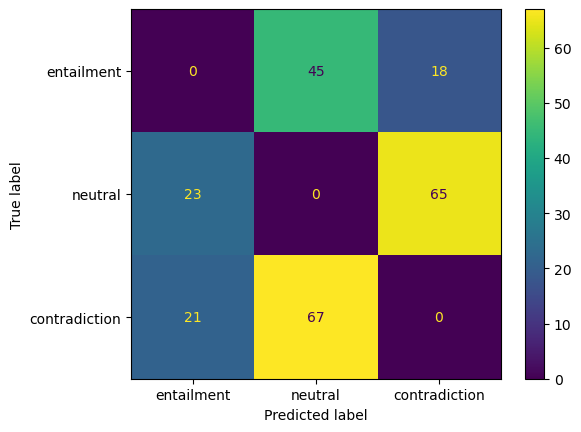

In [26]:
ConfusionMatrixDisplay.from_predictions(non_ambiguous_errors_df.label,
                                        non_ambiguous_errors_df.predicted_label,
                                        display_labels=['entailment','neutral','contradiction'])
plt.show()

In [ ]:
t0_and_p1_df = joined_df.query('label == 0 and predicted_label == 1')
print(f'{len(t0_and_p1_df)=}')

In [ ]:
t0_and_p1_df.to_csv('snli_errors/snli_t0_p1_errors.csv')

In [ ]:
t0_and_p1_df[['premise', 'hypothesis']].style.set_properties(**{'width': '500px'})

In [ ]:
t0_an_p2_df = joined_df.query('label == 0 and predicted_label == 2')
print(f'{len(t0_an_p2_df)=}')

In [ ]:
t0_an_p2_df.to_csv('snli_errors/snli_t0_p2_errors.csv')

In [ ]:
t0_an_p2_df[['premise', 'hypothesis']].style.set_properties(**{'width': '500px'})

In [ ]:
t0_an_p2_df[['premise', 'hypothesis', 'annotator_labels', 'predicted_scores']].style.set_properties(**{'width': '500px'})

This, in my opionion, is ambiguous:  
`Two players are on a wet field and one is on the ground.`:`There are only two people in the field.`  

Create contrast examples:  
`Two players are on a wet field and one of them is on the ground.`:`There are only two people in the field.`  
`Two players are on a wet field and one player is on the ground.`:`There are only two people in the field.`  
`Two players are on a wet field and one of the players is on the ground.`:`There are only two people in the field.`  
`Two players are on a wet field and one is on the ground.`:`There are only three people in the field.`  
`Three players are on a wet field and one is on the ground.`:`There are only three people in the field.`  
`Three players are on a wet field and one is on the ground.`:`There are only four people in the field.` 
`Two players are on a wet field and one is on the ground.`:`There are two people in the field.`  
`Two players are on a wet field and one is on the ground.`:`There are three people in the field.`  
`Two players are on a wet field and one is on the ground.`:`There are exactly two people in the field.`  
`Two players are on a wet field and one is on the ground.`:`There are exactly three people in the field.`  
`Two players are on a wet field and one is on the ground.`:`There is more than one person in the field.`  
`Two players are on a wet field and one is on the ground.`:`There are more than two people in the field.`  
`Two players are on a wet field and one is on the ground.`:`There are more than three people in the field.`  
`Two players are on a wet field and one is on the ground.`:`There are less than two people in the field.`  
`Two players are on a wet field and one is on the ground.`:`There are less than three people in the field.`  
`Two players are on a wet field and one is on the ground.`:`There are less than four people in the field.`  

`Two players are on a wet field and one of them is on the ground.`:`There are only two people on the field.`  
`Two players are on a wet field and one player is on the ground.`:`There are only two people on the field.`  
`Two players are on a wet field and one of the players is on the ground.`:`There are only two people on the field.`  
`Two players are on a wet field and one is on the ground.`:`There are only two people on the field.`  
`Two players are on a wet field and one is on the ground.`:`There are only three people on the field.`  
`Three players are on a wet field and one is on the ground.`:`There are only three people on the field.`  
`Three players are on a wet field and one is on the ground.`:`There are only four people on the field.` 
`Two players are on a wet field and one is on the ground.`:`There are two people on the field.`  
`Two players are on a wet field and one is on the ground.`:`There are three people on the field.`  
`Two players are on a wet field and one is on the ground.`:`There are exactly two people on the field.`  
`Two players are on a wet field and one is on the ground.`:`There are exactly three people on the field.`  
`Two players are on a wet field and one is on the ground.`:`There is more than one person on the field.`  
`Two players are on a wet field and one is on the ground.`:`There are more than two people on the field.`  
`Two players are on a wet field and one is on the ground.`:`There are more than three people on the field.`  
`Two players are on a wet field and one is on the ground.`:`There are less than two people on the field.`  
`Two players are on a wet field and one is on the ground.`:`There are less than three people on the field.`  
`Two players are on a wet field and one is on the ground.`:`There are less than four people on the field.`  

`Two players are on a dry field and one of them is on the ground.`:`There are only two people in the field.`  
`Two players are on a dry field and one player is on the ground.`:`There are only two people in the field.`  
`Two players are on a dry field and one of the players is on the ground.`:`There are only two people in the field.`  
`Two players are on a dry field and one is on the ground.`:`There are only two people on the field.`  
`Two players are on a dry field and one is on the ground.`:`There are only three people on the field.`  
`Three players are on a dry field and one is on the ground.`:`There are only three people on the field.`  
`Three players are on a dry field and one is on the ground.`:`There are only four people on the field.` 
`Two players are on a dry field and one is on the ground.`:`There are two people on the field.`  
`Two players are on a dry field and one is on the ground.`:`There are three people on the field.`  
`Two players are on a dry field and one is on the ground.`:`There are exactly two people on the field.`  
`Two players are on a dry field and one is on the ground.`:`There are exactly three people on the field.`  
`Two players are on a dry field and one is on the ground.`:`There is more than one person on the field.`  
`Two players are on a dry field and one is on the ground.`:`There are more than two people on the field.`  
`Two players are on a dry field and one is on the ground.`:`There are more than three people on the field.`  
`Two players are on a dry field and one is on the ground.`:`There are less than two people on the field.`  
`Two players are on a dry field and one is on the ground.`:`There are less than three people on the field.`  
`Two players are on a dry field and one is on the ground.`:`There are less than four people on the field.`  

`Two players are on a field and one of them is on the ground.`:`There are only two people in the field.`  
`Two players are on a field and one is on the ground.`:`There are only three people in the field.`  
`Three players are on a field and one is on the ground.`:`There are only three people in the field.`  
`Three players are on a field and one is on the ground.`:`There are only four people in the field.` 
`Two players are on a field and one is on the ground.`:`There are two people in the field.`  
`Two players are on a field and one is on the ground.`:`There are three people in the field.`  
`Two players are on a field and one is on the ground.`:`There are exactly two people in the field.`  
`Two players are on a field and one is on the ground.`:`There are exactly three people in the field.`  
`Two players are on a field and one is on the ground.`:`There is more than one person in the field.`  
`Two players are on a field and one is on the ground.`:`There are more than two people in the field.`  
`Two players are on a field and one is on the ground.`:`There are more than three people in the field.`  
`Two players are on a field and one is on the ground.`:`There are less than two people in the field.`  
`Two players are on a field and one is on the ground.`:`There are less than three people in the field.`  
`Two players are on a field and one is on the ground.`:`There are less than four people in the field.`  

`Two people are on a field and one of them is on the ground.`:`There are only two people in the field.`  
`Two people are on a field and one is on the ground.`:`There are only three people in the field.`  
`Three people are on a field and one is on the ground.`:`There are only three people in the field.`  
`Three people are on a field and one is on the ground.`:`There are only four people in the field.` 
`Two people are on a field and one is on the ground.`:`There are two people in the field.`  
`Two people are on a field and one is on the ground.`:`There are three people in the field.`  
`Two people are on a field and one is on the ground.`:`There are exactly two people in the field.`  
`Two people are on a field and one is on the ground.`:`There are exactly three people in the field.`  
`Two people are on a field and one is on the ground.`:`There is more than one person in the field.`  
`Two people are on a field and one is on the ground.`:`There are more than two people in the field.`  
`Two people are on a field and one is on the ground.`:`There are more than three people in the field.`  
`Two people are on a field and one is on the ground.`:`There are less than two people in the field.`  
`Two people are on a field and one is on the ground.`:`There are less than three people in the field.`  
`Two people are on a field and one is on the ground.`:`There are less than four people in the field.`  

Original:  
`Several men in protective suits are rolling a man on a gurnee.`:`A man is on a gurney`  
Contrast `entailment` examples:  
`Several women in protective suits are rolling a woman on a gurnee.`:`A woman is on a gurney`  
`Several men in protective suits are rolling a woman on a gurnee.`:`A woman is on a gurney`  
`Several men in blue suits are rolling a man on a gurnee.`:`A man is on a gurney`  
`Several men in protective gear are rolling a man on a gurnee.`:`A man is on a gurney`  
`Several men with long hair are rolling a man on a gurnee.`:`A man is on a gurney`  

`Several men in protective suits are rolling a man on a cart.`:`A man is on a cart`  
`Several women in protective suits are rolling a woman on a cart.`:`A woman is on a cart`  
`Several men in protective suits are rolling a woman on a cart.`:`A woman is on a cart`  
`Several men in blue suits are rolling a man on a cart.`:`A man is on a cart`  
`Several men in protective gear are rolling a man on a cart.`:`A man is on a cart`  
`Several men with long hair are rolling a man on a cart.`:`A man is on a cart`  

`Several men in protective suits are walking a man on a gurnee.`:`A man is on a gurnee`  
`Several women in protective suits are walking a woman on a gurnee.`:`A woman is on a gurnee`  
`Several men in protective suits are walking a woman on a gurnee.`:`A woman is on a gurnee`  
`Several men in blue suits are walking a man on a gurnee.`:`A man is on a gurnee`  
`Several men in protective gear are walking a man on a gurnee.`:`A man is on a gurnee`  
`Several men with long hair are walking a man on a gurnee.`:`A man is on a gurnee`  

`Several men in protective suits are rolling a man on a gurnee.`:`A man is on a gurney.`  
`Several women in protective suits are rolling a woman on a gurnee.`:`A woman is on a gurney.`  
`Several men in protective suits are rolling a woman on a gurnee.`:`A woman is on a gurney.`  
`Several men in blue suits are rolling a man on a gurnee.`:`A man is on a gurney.`  
`Several men in protective gear are rolling a man on a gurnee.`:`A man is on a gurney.`  
`Several men with long hair are rolling a man on a gurnee.`:`A man is on a gurney.`  

`Several men in protective suits are rolling a man on a gurnee`:`A man is on a gurney.`  
`Several women in protective suits are rolling a woman on a gurnee`:`A woman is on a gurney.`  
`Several men in protective suits are rolling a woman on a gurnee`:`A woman is on a gurney.`  
`Several men in blue suits are rolling a man on a gurnee`:`A man is on a gurney.`  
`Several men in protective gear are rolling a man on a gurnee`:`A man is on a gurney.`  
`Several men with long hair are rolling a man on a gurnee`:`A man is on a gurney.`  

`Several men in protective suits are rolling a man on a gurnee`:`A man is on a gurney`  
`Several women in protective suits are rolling a woman on a gurnee`:`A woman is on a gurney`  
`Several men in protective suits are rolling a woman on a gurnee`:`A woman is on a gurney`  
`Several men in blue suits are rolling a man on a gurnee`:`A man is on a gurney`  
`Several men in protective gear are rolling a man on a gurnee`:`A man is on a gurney`  
`Several men with long hair are rolling a man on a gurnee`:`A man is on a gurney`  


In [ ]:
def al_to_cnt(al):
    
    counter = Counter(al)
    return counter.most_common(1)[0][1]

def al_to_annotations_count(al):
    
    counter = Counter(al)
    return len(counter)

joined_df['majority_cnt'] = joined_df.apply(lambda x: annotators_label_to_cnt(x['annotator_labels']), axis=1)
joined_df['diff_annotations_cnt'] = joined_df.apply(lambda x: annotators_label_to_annotations_count(x['annotator_labels']), axis=1)

In [ ]:
ambiguous_df = joined_df.query("majority_cnt == 3")
slightly_ambiguous_df = joined_df.query("majority_cnt == 4")
non_ambiguous_df = joined_df.query("majority_cnt == 5")
even_split_df = joined_df.query("majority_cnt == 3 and diff_annotations_cnt == 2")

In [ ]:
len(ambiguous_df), len(even_split_df), len(slightly_ambiguous_df), len(non_ambiguous_df), len(joined_df)

In [ ]:
ambiguous_error_cnt = len(ambiguous_df.query("label != predicted_label"))
even_split_error_cnt = len(even_split_df.query("label != predicted_label"))
slightly_ambiguous_error_cnt = len(slightly_ambiguous_df.query("label != predicted_label"))
non_ambiguous_error_cnt = len(non_ambiguous_df.query("label != predicted_label"))
total_error_cnt = len(joined_df.query("label != predicted_label"))

ambiguous_error_rate = ambiguous_error_cnt/len(ambiguous_df)
even_split_error_rate = even_split_error_cnt/len(even_split_df)
slightly_ambiguous_error_rate = slightly_ambiguous_error_cnt/len(slightly_ambiguous_df)
non_ambiguous_error_rate = non_ambiguous_error_cnt/len(non_ambiguous_df)
total_error_rate = total_error_cnt/len(joined_df)
print(f'Ambiguous error count:          {ambiguous_error_cnt}/{len(ambiguous_df)}, {ambiguous_error_rate}, {1 - ambiguous_error_rate}')
print(f'Even split error count:         {even_split_error_cnt}/{len(even_split_df)}, {even_split_error_rate}, {1 - even_split_error_rate}')
print(f'Slightly ambiguous error count: {slightly_ambiguous_error_cnt}/{len(slightly_ambiguous_df)}, {slightly_ambiguous_error_rate}, {1 - slightly_ambiguous_error_rate}')
print(f'Non-ambiguous error count:      {non_ambiguous_error_cnt}/{len(non_ambiguous_df)}, {non_ambiguous_error_rate}, {1 - non_ambiguous_error_rate}')
print(f'Total error count:              {total_error_cnt}/{len(joined_df)}, {total_error_rate}, {1 - total_error_rate}')


In [ ]:
(ambiguous_error_cnt/total_error_cnt,
 even_split_error_cnt/total_error_cnt,
 slightly_ambiguous_error_cnt/total_error_cnt,
 non_ambiguous_error_cnt/total_error_cnt)

In [ ]:
(ambiguous_error_rate/total_error_rate,
 even_split_error_rate/total_error_rate,
 slightly_ambiguous_error_rate/total_error_rate,
 non_ambiguous_error_rate/total_error_rate)

In [ ]:
(len(ambiguous_df)/len(joined_df),
 len(even_split_df)/len(joined_df),
 len(slightly_ambiguous_df)/len(joined_df),
 len(non_ambiguous_df)/len(joined_df))

### Ambiguous Data
_Ambiguous_ data are data that only received 3 votes for the majority by the annotators.

Errors on _ambiguous_ data account for 45.6% of the total errors. With only 15.4% of the data examples, we see that those data that are considered _ambibuous_ are almost 3 times (2.97x) more likely to be labeled incorrectly by the model compared to the entire dataset. It should also be noted that those _ambiguous_ data where there was a near even split (i.e., 3 for one label and 2 for another) are even more likely (3.11x) to be labeled incorrectly by the model compared to the entire dataset. It should also be noted that _unambiguous_ data (i.e., those data where all the annotators agreed on the label) are less than half (.41x) as likely to be labeled incorrectly by the model compared to the entire dataset.

In [ ]:
ConfusionMatrixDisplay.from_predictions(ambiguous_df.label, ambiguous_df.predicted_label, display_labels=['entailment','neutral','contradiction'])
ConfusionMatrixDisplay.from_predictions(even_split_df.label, even_split_df.predicted_label, display_labels=['entailment','neutral','contradiction'])
ConfusionMatrixDisplay.from_predictions(slightly_ambiguous_df.label, slightly_ambiguous_df.predicted_label, display_labels=['entailment','neutral','contradiction'])
ConfusionMatrixDisplay.from_predictions(non_ambiguous_df.label, non_ambiguous_df.predicted_label, display_labels=['entailment','neutral','contradiction'])
ConfusionMatrixDisplay.from_predictions(joined_df.label, joined_df.predicted_label, display_labels=['entailment','neutral','contradiction'])
plt.show()


Ambiguous (exactly 3 for one label):  
* A0: Ambiguous with majority 0
* A1: Ambiguous with majority 1
* A2: Ambiguous with majority 2

Slightly ambiguous (exactly 4 for one label):  
* S0: Slightly ambiguous with majority 0
* S1: Slightly ambiguous with majority 1
* S2: Slightly ambiguous with majority 2

Unambiguous (exactly 5 for one label):  
* U0: Umbiguous with majority 0
* U1: Umbiguous with majority 1
* U2: Umbiguous with majority 2

In [ ]:
%ls -al ../data/snli_1.0

In [ ]:
train_snli_df = pd.read_json('../data/snli_1.0/snli_1.0_train.jsonl', lines=True)

In [ ]:
train_snli_df.head(5)

In [ ]:
label_dict = {'entailment':'0', 'neutral':'1', 'contradiction':'2'}
ambiguous_dict = {3: 'A', 4:'S', 5: 'U'}
def al_to_cnt(al):
    
    counter = Counter(al)
    most_common = counter.most_common(1)[0]
    category = most_common[0]
    count = most_common[1]
    
    label = ambiguous_dict[count] + label_dict[category]
    
    return label

def al_to_annotations_count(al):
    
    counter = Counter(al)
    return len(counter)

In [ ]:
train_snli_df['amb_label'] = train_snli_df.apply(lambda x: al_to_cnt(x['annotator_labels']), axis=1)
# joined_df['diff_annotations_cnt'] = joined_df.apply(lambda x: annotators_label_to_annotations_count(x['annotator_labels']), axis=1)

In [ ]:
joined_df.head()